In [143]:
# Samarth Ganesh Thopaiah ~ Machine learning for signal processing 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from datetime import date
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as smapi
from sklearn.metrics import mean_squared_error
import yfinance as yf
import os, contextlib
import glob
from tqdm.auto import tqdm

C:\Users\thopa\AppData\Local\Temp\ipykernel_6900\4199000192.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime
d:\anaconda\envs\MachineLearningSP\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# # create a folder for data storage
# if not os.path.exists("stocks data"):
#     os.mkdir("stocks data")

# # read the NASDAQ 100 Index ticker symbols list from Wiki
# url = 'https://en.wikipedia.org/wiki/NASDAQ-100#Components'
# html = pd.read_html(url, header=0)
# series = html[4]["Ticker"]
# symbols = series.to_list()
# # download prices history
# with open(os.devnull, 'w') as devnull:
#     with contextlib.redirect_stdout(devnull):
#         for i, symbol in enumerate(symbols):
#             data = yf.download(symbol, period='max')["Close"]
#             data.to_csv('stocks data/{}.csv'.format(symbol))

In [ ]:
path = "stocks_dataCLOSE/"
csv_files = glob.glob(os.path.join(path, "*.csv"))
stocks_dict = {}

# loop over the list of csv files
for f in csv_files:      
    # read the csv file
    df = pd.read_csv(f)
      
    # print the location and filename
    print('Location:', f)
    print('File Name:', f.split("/")[-1])
      
    # print the content
    print('Content:')
    display(df)

In [189]:
# Working with a single stock 
# This signal has 1170 discrete values. We use the LMS algorithm to learn the filter weights 
# Teacher forcing approach at each step 

path = "stocks_dataCLOSE/"
csv_files = glob.glob(os.path.join(path, "GOOGL.csv"))
df = pd.read_csv(csv_files[0])
signal = df['Close']

# Quantizing for more accuracy ?
# Smoothing with an LPF might also work 
signal = [np.floor(i) for i in signal]
signal = np.array(signal)

In [190]:
class lmsPred:
    def __init__(self, u):
        # Do not alter this ~ zeros out prediction for the last day 
        self.l = 1
        self.u = u
        self.N = 70

        # Weight initialization
        self.wn=np.random.rand(self.N+1,1)/10
          
    def train(self, x):
        xd= np.block([np.zeros((1,self.l)), x]).T
        y=np.zeros((len(xd),1))
        xn=np.zeros((self.N+1,1))
        xn = np.matrix(xn)
        M=len(xd)
        for n in range(0,M):
            xn = np.block([[xd[n]], [xn[0:self.N]]])

            # Gradient clips at this step 
            y[n]= np.matmul(self.wn.T, xn)


            if -10 > np.sum(self.wn) > 10:
                print(self.wn)
                break  

            if(n>M-self.l-1):
                e = 0
            else:
                e= int(x[n]-y[n])
            self.wn = self.wn + 2*self.u*e*xn
        return y

    def predictToday(self):
        today = date.today()
        print("Today's date:{}".format(today))
        
        
 



Filter is fine-tuning on prior data.... 


100%|██████████| 4557/4557 [00:08<00:00, 554.64it/s]


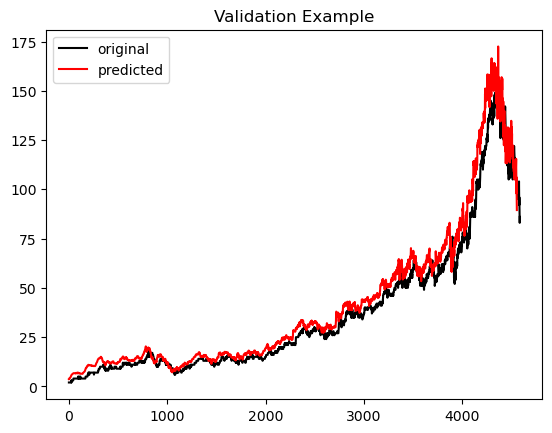

For every window size of 30,  we used 29 to learn the filter weights and 1 for validation.
We accumulate these validation scores and calcualte the MSE and MAE below:
Company: Google
Mean Squared Error:  26.10183536310893
Mean Absolute Error: 4.1284360046412445


In [191]:
#  Initialize a new LMS predictor class
#  For tuning the hyperparameters 

# Parameters to consider [ u = learning rate, l = number of outputs to predict, N = filter order, x = input vector ]
# Wise to consider a smaller window ~ Ideal window size for stock market prediction

x_train = signal
x_train_max = np.max(x_train)
if x_train_max > 200:
    k = 1
else: 
    k = 0 
lr_options = [2**(-20), 2**(-30)]

predClass = lmsPred(lr_options[k])

real_values, pred_values = [], []
print("Filter is fine-tuning on prior data.... ")

# We set the learning rate depending on the max 

for i in tqdm(range(len(x_train)-30)):
    x = x_train[i:i+30]
    result = predClass.train(x)
    pred = result[-1:]
    pred_values.append(np.squeeze(pred))
    real = x[-1]
    real_values.append(x[-1])
    
plt.plot(x_train, color = 'black')
plt.plot(pred_values, color = 'red')
plt.legend(["original", "predicted"])
plt.title("Validation Example")
plt.show()


# Printout relevant metrics
print("For every window size of 30,  we used 29 to learn the filter weights and 1 for validation.\nWe accumulate these validation scores and calcualte the MSE and MAE below:")
print("Company: Google")
print("Mean Squared Error: ",mean_squared_error(real_values, pred_values) )
print("Mean Absolute Error:", mean_absolute_error(real_values, pred_values))


### GLOBAL Validation
- Closing price prediction across all companies ~ 100 models trained
- Similar hyperparameters? 
- Data preprocessing considerations? 

In [188]:
# 2022-11-04

path = "stocks_dataCLOSE/"
csv_files = glob.glob(os.path.join(path, "*.csv"))
text_file = open("C:\\Users\\thopa\\Desktop\\Assignments\\11755_MLforSP\\Project\\AdaptiveFiltering\\log.txt","w")
# Primary validation loop 
# Extremely slow code ~ Scope for optimization (Any suggestions Anthony or Daniel?)

print("Filter is fine-tuning on prior data on all companies listed... ")
for j in tqdm(csv_files):
    df = pd.read_csv(j)
    signal = df['Close']
    signal = [np.floor(k) for k in signal]
    signal = np.array(signal)

    # New adaptive filter for every company 

    x_train = signal

    # Some steps to avoid gradient explosing or vanishing 
    x_train_max = np.max(x_train)
    if x_train_max > 200:
        k = 1
    else: 
        k = 0 
    lr_options = [2**(-20), 2**(-30)]
    predClass = lmsPred(lr_options[k])


    real_values, pred_values = [], []
    for i in range(len(x_train)-30):
        x = x_train[i:i+30]
        result = predClass.train(x)
        pred = result[-1:]
        pred_values.append(np.squeeze(pred))
        real = x[-1]
        real_values.append(x[-1])
    string = "Company {} | MSE: {} | MAE: {} \n".format(j.split("\\")[-1].split(".")[-2],mean_squared_error(real_values, pred_values), mean_absolute_error(real_values, pred_values))
    text_file.write(string)
    text_file.flush()

    
text_file.close()


Filter is fine-tuning on prior data on all companies listed... 


100%|██████████| 102/102 [19:10<00:00, 11.28s/it]
